In [1]:
from lib_learning.nn_monitoring.activations import ActivationMonitor
from lib_learning.nn_monitoring.weights import WeightMonitor
from lib_learning.nn_monitoring.gradient import LossGradientMonitor, LossGradientNormMonitor
from lib_learning.nn_monitoring.loss import LossMonitor

from lib_learning.nn.ffnn import FFNN
from lib_learning.nn.cnn import CNN
from lib_learning.nn.nn_base_class import NN

from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import tensorflow as tf
import gzip

import plotly.offline as plotly
import plotly.graph_objs as go
from PIL import Image

In [2]:
%matplotlib inline
plotly.init_notebook_mode(connected=True)

# Data

In [3]:
with gzip.open('../data/MNIST_data/test_inputs.gz', 'rb') as f:
    test_in = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28) / 255.0
with gzip.open('../data/MNIST_data/train_inputs.gz', 'rb') as f:
    train_in = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28) / 255.0
with gzip.open('../data/MNIST_data/test_targets.gz', 'rb') as f:
    test_labels_raw = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open('../data/MNIST_data/train_targets.gz', 'rb') as f:
    train_labels_raw = np.frombuffer(f.read(), np.uint8, offset=8)
    
test_labels = np.zeros((test_labels_raw.shape[0], 10))
test_labels[np.arange(test_labels_raw.shape[0]), test_labels_raw] = 1
train_labels = np.zeros((train_labels_raw.shape[0], 10))
train_labels[np.arange(train_labels_raw.shape[0]), train_labels_raw] = 1

test_in = test_in.astype('float32')
train_in = train_in.astype('float32')
test_lables = test_labels.astype('float32')
train_lables = train_labels.astype('float32')

In [4]:
# Run this if you want to normalize to zero mean
test_in = test_in - train_in.mean()
train_in = train_in - train_in.mean()

# Simple Autoencoder

In [8]:
d = tf.data.Dataset.from_tensor_slices((train_in, train_in))
d = d.repeat(50)
d = d.batch(300)
d = d.shuffle(5000)
iterator = d.make_initializable_iterator()
pipe_out = iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [9]:
lc = [
    784,
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 2, 'activation': tf.identity, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 784, 'activation': tf.identity, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    }
]

In [10]:
monitors = [LossMonitor(200)]

In [11]:
ffnn = FFNN(
    lc, monitors=monitors, optimizer=tf.train.AdamOptimizer(), input_vector=pipe_out[0], train_targets_vector=pipe_out[1]
)
ffnn.init_session()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [12]:
%%time
for epoch in range(40):
    ffnn.session.run(iterator.initializer)
    ffnn.train_online()

CPU times: user 4h 10min 4s, sys: 20min 24s, total: 4h 30min 28s
Wall time: 1h 1min 13s


In [13]:
plotly.iplot([go.Scatter(
    x=ffnn.monitors[0].values['epochs'],
    y=ffnn.monitors[0].values['loss'].ewm(alpha=0.1).mean()
)])

In [14]:
plotly.iplot(ffnn.monitors[0].plot())

In [15]:
inp = tf.placeholder(tf.float32, shape=(None, 784))
outp = inp
for i in range(4):
    w = ffnn.weights[i]
    b = ffnn.biases[i]
    a = ffnn.activation[i]
    outp = a(tf.matmul(outp, w) + b)
    

outp = ffnn.session.run(outp, feed_dict={inp: train_in[:20000]})

In [16]:
figure = go.Figure(
    data=[
        go.Scattergl(
            x=outp[train_labels.argmax(axis=1)[:20000] == i, 0],
            y=outp[train_labels.argmax(axis=1)[:20000] == i, 1],
            mode='markers',
            marker={'size': 2, 'opacity': 1},
            name='{}'.format(i)
        )
        for i in range(10)
    ]
)

plotly.iplot(figure)

# UNet Convolutional Autoencoder

In [5]:
batch_size = 100
d = tf.data.Dataset.from_tensor_slices((train_in.reshape((60000, 28, 28, 1)), train_in))
d = d.repeat(50)
d = d.batch(batch_size)
d = d.shuffle(5000)
iterator = d.make_initializable_iterator()
pipe_out = iterator.get_next()
pipe_out[0].set_shape([batch_size, 28, 28, 1])

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [6]:
lc = [
    {
        'layer_type': 'conv',
        'filter_size': [6, 6, 1, 32],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 2, 2, 1],
        'activation': tf.tanh,
        'output_size': [12, 12, 32]
    },
    {
        'layer_type': 'conv',
        'filter_size': [6, 6, 32, 32],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 2, 2, 1],
        'activation': tf.tanh,
        'output_size': [4, 4, 32]
    },
    {
        'layer_type': 'conv',
        'filter_size': [4, 4, 32, 64],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 2, 2, 1],
        'activation': tf.tanh,
        'output_size': [1, 1, 64]
    },
    {
        'layer_type': 'conv',
        'filter_size': [1, 1, 64, 2],
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,       
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.identity,
        'output_size': [1, 1, 2]
    },
    {
        'layer_type': 'conv_transpose',
        'filter_size': [1, 1, 64, 2],
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [1, 1, 64]
    },
    {
        'layer_type': 'conv_transpose',
        'filter_size': [4, 4, 32, 64],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 2, 2, 1],
        'activation': tf.tanh,
        'output_size': [4, 4, 32]
    },
    {
        'layer_type': 'conv_transpose',
        'filter_size': [6, 6, 32, 32],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 2, 2, 1],
        'activation': tf.tanh,
        'output_size': [12, 12, 32]
    },
    {
        'layer_type': 'conv_transpose',
        'filter_size': [6, 6, 1, 32],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 2, 2, 1],
        'activation': tf.tanh,
        'output_size': [28, 28, 1]
    },
    {
        'layer_type': 'reshape',
        'new_shape': [784]
    }
]

In [7]:
monitors = [LossMonitor(200)]

In [9]:
cnn = CNN(
    lc, monitors=monitors, optimizer=tf.train.AdamOptimizer(),
    input_vector=pipe_out[0],
    train_targets_vector=pipe_out[1]
)
cnn.init_session()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [20]:
%%time
for epoch in range(10):
    cnn.session.run(iterator.initializer)
    cnn.train_online()

In [12]:
plotly.iplot([go.Scatter(
    x=cnn.monitors[0].values['epochs'],
    y=cnn.monitors[0].values['loss'].ewm(alpha=0.1).mean()
)])

In [13]:
plotly.iplot(cnn.monitors[0].plot())

## Plot Embedding

In [14]:
def feed_forwards(self, input_vector, n):
    for i in range(n):
        lc = self.lc[i]

        if lc['layer_type'] == 'conv':
            input_vector = tf.nn.conv2d(
                input=input_vector,
                filter=lc['filter'],
                strides=lc['stride_size'],
                padding='VALID'
            )
            input_vector = lc['activation'](input_vector)

        elif lc['layer_type'] == 'conv_transpose':
            input_vector = tf.nn.conv2d_transpose(
                value=input_vector,
                filter=lc['filter'],
                output_shape=lc['output_size'],
                strides=lc['stride_size'],
                padding='VALID'
            )
            input_vector = lc['activation'](input_vector)

        elif lc['layer_type'] == 'connected':
            a = lc['activation']
            w = lc['weights']
            b = lc['biases']
            input_vector = a(tf.matmul(input_vector, w) + b)

        elif lc['layer_type'] == 'pool':
            if lc['pool_type'] == 'average':
                input_vector = tf.nn.avg_pool(
                    value=input_vector,
                    ksize=lc['pool_size'],
                    strides=lc['stride_size'],
                    padding='SAME'
                )
            elif lc['pool_type'] == 'max':
                input_vector = tf.nn.max_pool(
                    value=input_vector,
                    ksize=lc['pool_size'],
                    strides=lc['stride_size'],
                    padding='SAME'
                )

        elif lc['layer_type'] == 'reshape':
            input_vector = tf.reshape(input_vector, [-1] + lc['new_shape'])

    return input_vector

In [15]:
inp = tf.placeholder(tf.float32, (None, 28, 28, 1))
outp = feed_forwards(cnn, inp, 4)
outp = cnn.session.run(outp, feed_dict={inp: train_in.reshape((60000, 28, 28, 1))[:20000]})
outp = outp.reshape((20000, 2))

In [16]:
figure = go.Figure(
    data=[
        go.Scattergl(
            x=outp[train_labels.argmax(axis=1)[:20000] == i, 0],
            y=outp[train_labels.argmax(axis=1)[:20000] == i, 1],
            mode='markers',
            marker={'size': 2, 'opacity': 1},
            name='{}'.format(i)
        )
        for i in range(10)
    ]
)

plotly.iplot(figure)

## Visualize Filters

In [17]:
filters_1 = cnn.session.run(cnn.lc[0]['filter'])

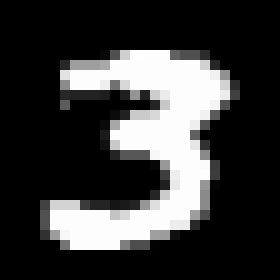

In [18]:
n = 27
image = train_in.reshape((60000, 28, 28, 1))[n:n+1, :, :, :]

f1 = np.repeat(image[0,:,:,0], 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')